In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('filtered_data_mimed0101.csv')
df.head()

,Type,adjusted_time_ints,adjusted_time,Price,Volume
0,ask,0.0,0 days 00:00:00,258.684211,2.0
1,ask,1.0,0 days 00:01:00,254.000000,5.0
2,ask,2.0,0 days 00:02:00,258.000000,1.0
3,ask,3.0,0 days 00:03:00,259.000000,4.0
4,ask,4.0,0 days 00:04:00,261.000000,2.0


In [6]:
df_ask = df[df['Type'] == 'ask']
df_ask.reset_index(drop=True, inplace=True)
df_bid = df[df['Type'] == 'bid']
df_bid.reset_index(drop=True, inplace=True)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
# set seed
torch.manual_seed(42)

# min-max normalization
scaler_ask = MinMaxScaler()
df_normalized_ask = pd.DataFrame(scaler_ask.fit_transform(df_ask[['Price']]), columns=['Price'])

scaler_bid = MinMaxScaler()
df_normalized_bid = pd.DataFrame(scaler_bid.fit_transform(df_bid[['Price']]), columns=['Price'])


tensor_data_ask = torch.FloatTensor(df_normalized_ask.values)
tensor_data_bid = torch.FloatTensor(df_normalized_bid.values)


# create sequences
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append(seq)
        labels.append(label)
    return torch.stack(sequences), torch.stack(labels)


input_size = 1  
hidden_size = 64
output_size = 1 
seq_length = 60 

sequences_ask, labels_ask = create_sequences(tensor_data_ask, seq_length)
sequences_bid, labels_bid = create_sequences(tensor_data_bid, seq_length)

train_size_ask = int(len(sequences_ask) * 0.80)
test_size_ask = len(sequences_ask) - train_size_ask
train_sequences_ask, test_sequences_ask = sequences_ask[:train_size_ask], sequences_ask[train_size_ask:]
train_labels_ask, test_labels_ask = labels_ask[:train_size_ask], labels_ask[train_size_ask:]

train_size_bid = int(len(sequences_bid) * 0.80)
test_size_bid = len(sequences_bid) - train_size_bid
train_sequences_bid, test_sequences_bid = sequences_bid[:train_size_bid], sequences_bid[train_size_bid:]
train_labels_bid, test_labels_bid = labels_bid[:train_size_bid], labels_bid[train_size_bid:]


# create data loader
train_dataset_ask = TensorDataset(train_sequences_ask, train_labels_ask)
test_dataset_ask = TensorDataset(test_sequences_ask, test_labels_ask)

train_loader_ask = DataLoader(train_dataset_ask, batch_size=64, shuffle=True)
test_loader_ask = DataLoader(test_dataset_ask, batch_size=64, shuffle=False)


train_dataset_bid = TensorDataset(train_sequences_bid, train_labels_bid)
test_dataset_bid = TensorDataset(test_sequences_bid, test_labels_bid)

train_loader_bid = DataLoader(train_dataset_bid, batch_size=64, shuffle=True)
test_loader_bid = DataLoader(test_dataset_bid, batch_size=64, shuffle=False)



In [9]:
# define model
class GRU(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(GRU, self).__init__()
       
        self.hidden_size = hidden_size
        
        self.num_layers = num_layers

        self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):

        # initialize hidden state with zeros
        hn = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        hn = hn.to(device)
        out, _ = self.rnn(x,hn)

        out = self.fc(out[:, -1, :])

        return out


# define evaluation function
def evaluate_model(model, loader, criterion):

    model.eval()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    # without computing gradients
    with torch.no_grad():
        for batch_sequences, batch_labels in loader:  
            batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)

            outputs = model(batch_sequences)
            loss = criterion(outputs.squeeze(), batch_labels.squeeze())
           
            all_labels.extend(batch_labels.cpu().numpy().flatten())
            all_predictions.extend(outputs.cpu().numpy().flatten())

            total_loss += loss.item()

    # calculate average loss
    average_loss = total_loss / len(loader)  

    # calculate metrics
    mae = mean_absolute_error(all_labels, all_predictions)
    mse = mean_squared_error(all_labels, all_predictions)
    rmse = sqrt(mse)

    return average_loss, mae, mse, rmse, all_labels, all_predictions



In [137]:
# create model
model_ask = GRU(input_size, hidden_size, output_size, num_layers=1, dropout=0.2).to(device)

criterion = nn.MSELoss()
optimizer_ask = optim.Adam(model_ask.parameters(), lr=0.001)

df_results = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Train RMSE', 'Test Loss', 'Test MAE', 'Test MSE', 'Test RMSE'])

num_epochs = 50
test_mae_list = []
test_mse_list = []
test_rmse_list = []
test_loss_list = []

train_rmse_list = []
train_loss_list = []

for epoch in range(num_epochs):
    
    model_ask.train()
    for batch_sequences, batch_labels in train_loader_ask:
        batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)

        optimizer_ask.zero_grad()
        outputs = model_ask(batch_sequences)

        loss = criterion(outputs.squeeze(), batch_labels.squeeze())
        loss.backward()
        optimizer_ask.step()

    # evaluate model
    train_loss, train_mae, train_mse, train_rmse, test_label, predicted_labels = evaluate_model(model_ask, train_loader_ask, criterion)
    test_loss, test_mae, test_mse, test_rmse, test_label, predicted_labels = evaluate_model(model_ask, test_loader_ask, criterion)
    
    print(f'Epoch [{epoch+1}/{num_epochs}],Train Loss: {train_loss:.6f}, Train RMSE: {train_rmse:.6f}, Test Loss: {test_loss:.6f}, Test MAE: {test_mae:.4f}, Test MSE: {test_mae:.4f}, Test RMSE: {test_rmse:.4f}')

    df_results.loc[len(df_results)] = [epoch+1, train_loss, train_rmse, test_loss, test_mae, test_mse, test_rmse]

    test_mae_list.append(test_mae)
    test_mse_list.append(test_mse)
    test_rmse_list.append(test_rmse)
    test_loss_list.append(test_loss)

    train_loss_list.append(train_loss)
    train_rmse_list.append(train_rmse)




Epoch [1/50],Train Loss: 0.000449, Train RMSE: 0.021197, Test Loss: 0.000467, Test MAE: 0.0175, Test MSE: 0.0175, Test RMSE: 0.0216
Epoch [2/50],Train Loss: 0.000454, Train RMSE: 0.021308, Test Loss: 0.000608, Test MAE: 0.0186, Test MSE: 0.0186, Test RMSE: 0.0247
Epoch [3/50],Train Loss: 0.000362, Train RMSE: 0.019018, Test Loss: 0.000407, Test MAE: 0.0177, Test MSE: 0.0177, Test RMSE: 0.0202
Epoch [4/50],Train Loss: 0.000358, Train RMSE: 0.018913, Test Loss: 0.000486, Test MAE: 0.0173, Test MSE: 0.0173, Test RMSE: 0.0220
Epoch [5/50],Train Loss: 0.000369, Train RMSE: 0.019211, Test Loss: 0.000406, Test MAE: 0.0177, Test MSE: 0.0177, Test RMSE: 0.0201
Epoch [6/50],Train Loss: 0.000356, Train RMSE: 0.018861, Test Loss: 0.000455, Test MAE: 0.0172, Test MSE: 0.0172, Test RMSE: 0.0213
Epoch [7/50],Train Loss: 0.000441, Train RMSE: 0.020993, Test Loss: 0.000418, Test MAE: 0.0174, Test MSE: 0.0174, Test RMSE: 0.0205
Epoch [8/50],Train Loss: 0.000355, Train RMSE: 0.018845, Test Loss: 0.000420

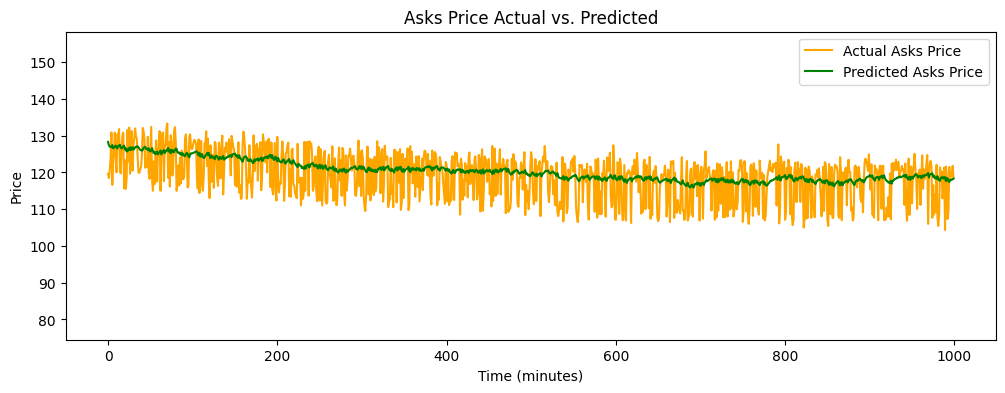

[[128.28369 ]
 [127.41203 ]
 [127.03    ]
 ...
 [106.61745 ]
 [106.450745]
 [106.15204 ]]
(12738, 1)
Data exported to GRU_predicted_ask_prices.csv


In [163]:
import matplotlib.pyplot as plt

# plot the comparison
plt.figure(figsize=(12, 4))

test_label_ask = scaler_ask.inverse_transform(test_labels_ask.cpu().numpy().flatten().reshape(-1, 1))
predicted_labels_ask = scaler_ask.inverse_transform(np.array(predicted_labels).reshape(-1, 1))

plt.plot(test_label_ask[:1000], color='orange', label='Actual Asks Price')
plt.ylim(min(test_label_ask) - 30, max(test_label_ask) + 30)  
plt.plot(predicted_labels_ask[:1000], color='green', label='Predicted Asks Price')
plt.ylim(min(predicted_labels_ask) - 30, max(predicted_labels_ask) + 30)  

plt.xlabel('Time (minutes)')
plt.ylabel('Price')
plt.legend()
plt.title('Asks Price Actual vs. Predicted')
plt.show()

print(predicted_labels_ask)
print(predicted_labels_ask.shape)

data = {  
    'ASK Price Predicted': predicted_labels_ask.flatten() 
}

df = pd.DataFrame(data)

csv_file_path = 'GRU_predicted_ask_prices.csv'
df.to_csv(csv_file_path, index=False)

print(f"Data exported to {csv_file_path}")




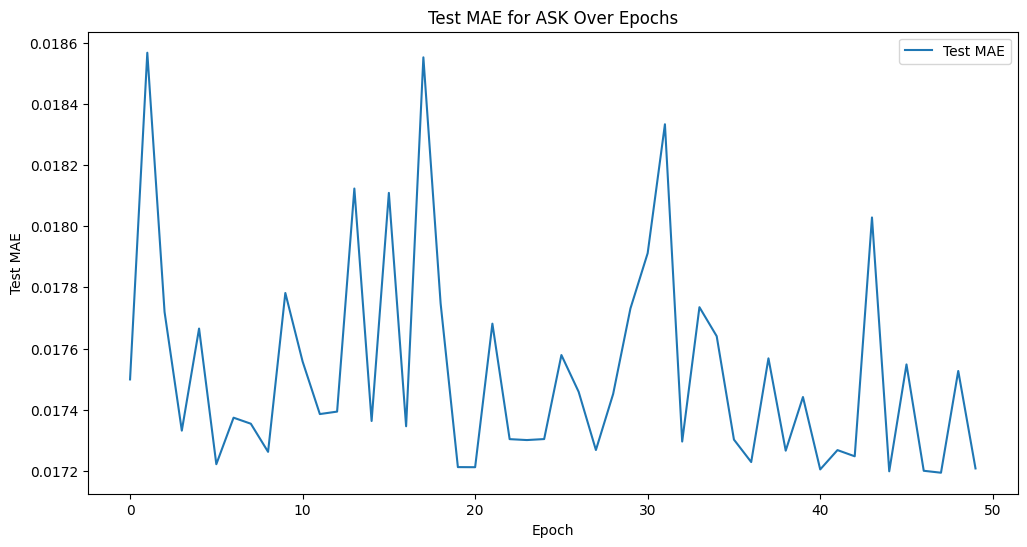

In [140]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_mae_list, label='Test MAE')
plt.xlabel('Epoch')
plt.ylabel('Test MAE')
plt.legend()
plt.title('Test MAE for ASK Over Epochs')
plt.show()

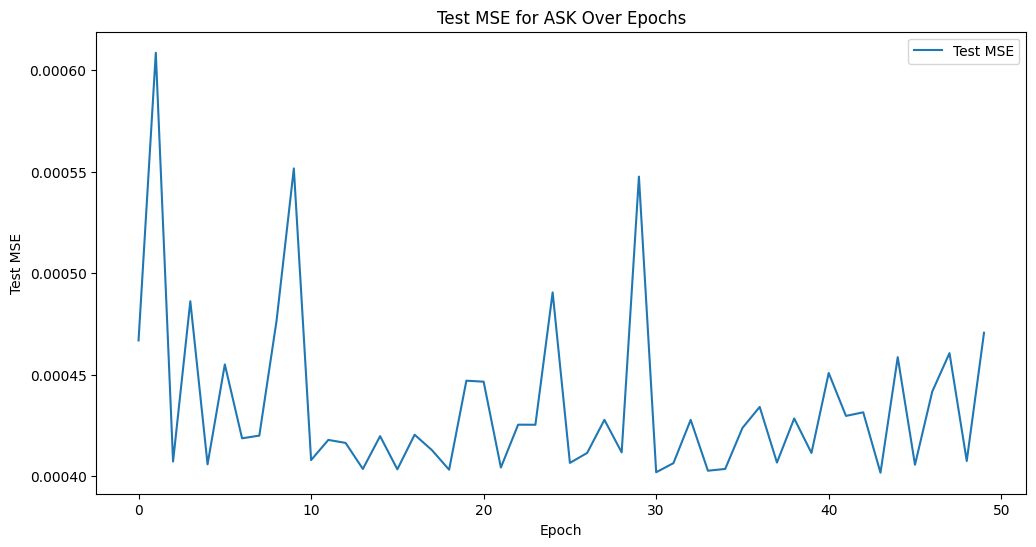

In [141]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_mse_list, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('Test MSE')
plt.legend()
plt.title('Test MSE for ASK Over Epochs')
plt.show()

[0.02160800709979711, 0.024667332158516582, 0.02018204371302581, 0.022049848412826395, 0.020147812492595056, 0.02133296518524549, 0.020462769332368607, 0.020495158219583805, 0.02183314778390185, 0.023484819298337047, 0.020199421053352665, 0.020443488326221327, 0.020407497338903034, 0.020091160556537913, 0.020488630701835965, 0.020086198527097063, 0.02050605621651262, 0.02032088553097516, 0.020081708463988213, 0.02114430226702887, 0.02113269019664411, 0.020108516569755316, 0.02062615595115047, 0.020625036279780094, 0.022147937843449178, 0.020165093045225003, 0.02028597471863944, 0.02068388729431986, 0.02029286573868528, 0.02339906322298541, 0.020050585897791982, 0.02016168012612917, 0.02068318092940126, 0.020069289446948555, 0.020091097542825655, 0.020586777125704284, 0.02083701413825992, 0.02016924276346384, 0.020699850759164036, 0.02028614257520649, 0.02123370837662752, 0.020730412045969666, 0.02077308658581962, 0.02004474485547395, 0.021415946233448235, 0.020142171591581996, 0.021016

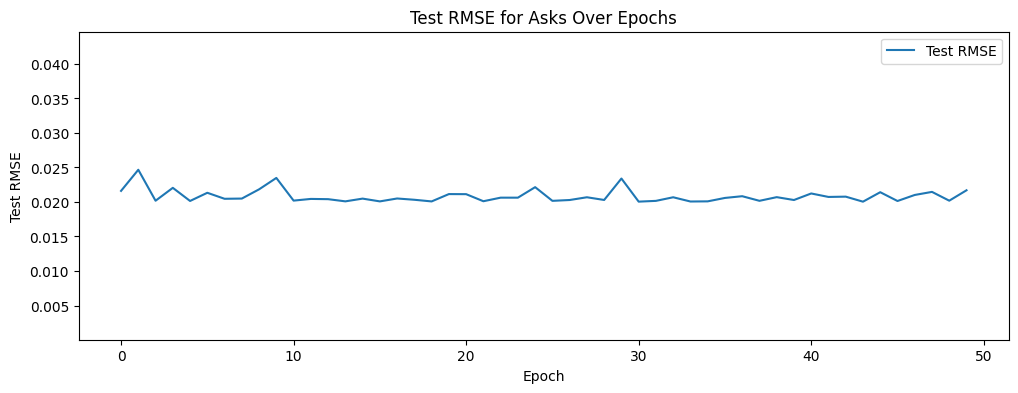

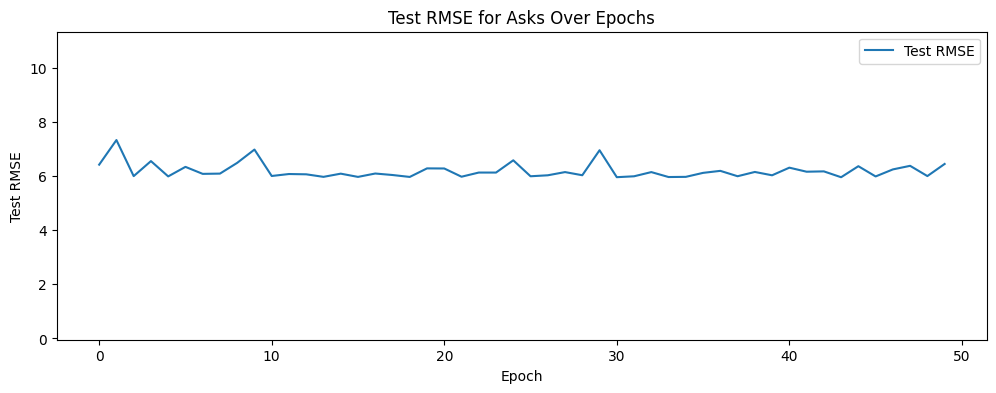

In [166]:
import matplotlib.pyplot as plt

print(test_rmse_list)
print(len(test_rmse_list))
scaled_rmse_list = [x * 297 for x in test_rmse_list]
np_array = np.array(scaled_rmse_list)
np_array_transposed = np_array.reshape(-1, 1)

print(len(scaled_rmse_list))
print(scaled_rmse_list)
print(np_array_transposed)

plt.figure(figsize=(12, 4))
plt.plot(test_rmse_list, label='Test RMSE')
plt.ylim(min(test_rmse_list) - 0.02, max(test_rmse_list) + 0.02) 
plt.xlabel('Epoch')
plt.ylabel('Test RMSE')
plt.legend()
plt.title('Test RMSE for Asks Over Epochs')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(scaled_rmse_list, label='Test RMSE')
plt.ylim(min(scaled_rmse_list) - 6, max(scaled_rmse_list) + 4)  
plt.xlabel('Epoch')
plt.ylabel('Test RMSE')
plt.legend()
plt.title('Test RMSE for Asks Over Epochs')
plt.show()

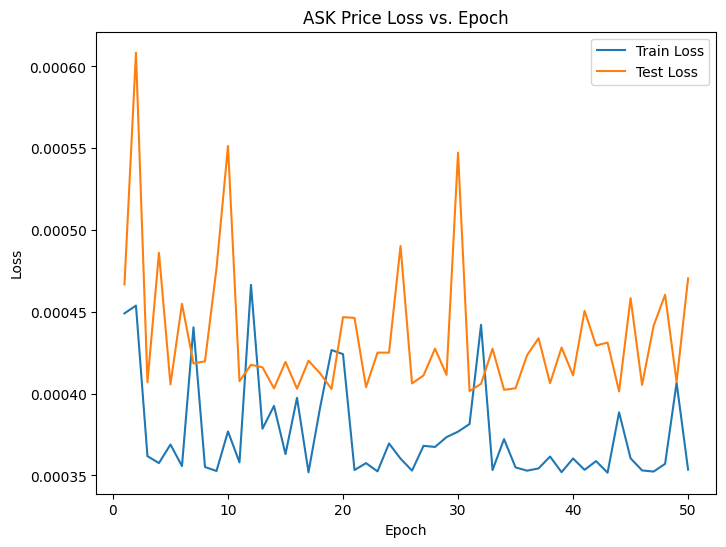

In [144]:
import matplotlib.pyplot as plt

# plot the loss
plt.figure(figsize=(8, 6))
plt.plot(df_results['Epoch'].values, df_results['Train Loss'].values, label='Train Loss')
plt.plot(df_results['Epoch'].values, df_results['Test Loss'].values, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('ASK Price Loss vs. Epoch')
plt.show()


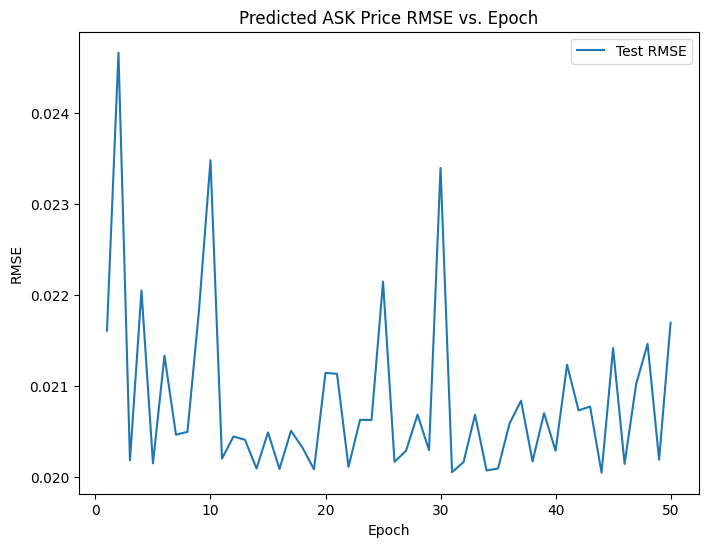

In [145]:
# plot RMSE
plt.figure(figsize=(8, 6))
plt.plot(df_results['Epoch'].values, df_results['Test RMSE'].values, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.title('Predicted ASK Price RMSE vs. Epoch')
plt.show()

In [149]:
# create model
model_bid = GRU(input_size, hidden_size, output_size, num_layers=1, dropout=0.2).to(device)

criterion = nn.MSELoss()
optimizer_bid = optim.Adam(model_bid.parameters(), lr=0.001)

df_results = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Train RMSE', 'Test Loss', 'Test MAE', 'Test MSE', 'Test RMSE'])

# train model
num_epochs = 50

test_mae_list_b = []
test_mse_list_b = []
test_rmse_list_b = []
test_loss_list_b = []

train_rmse_list_b = []
train_loss_list_b = []

for epoch in range(num_epochs):
    
    model_bid.train()
    for batch_sequences, batch_labels in train_loader_bid:
        batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)

        optimizer_bid.zero_grad()
        outputs = model_bid(batch_sequences)

        loss = criterion(outputs.squeeze(), batch_labels.squeeze())
        loss.backward()
        optimizer_bid.step()

    # evaluate model
    train_loss_b, train_mae_b, train_mse_b, train_rmse_b, test_label_b, predicted_labels_b = evaluate_model(model_bid, train_loader_bid, criterion)
    test_loss_b, test_mae_b, test_mse_b, test_rmse_b, test_label_b, predicted_labels_b = evaluate_model(model_bid, test_loader_bid, criterion)
    print(f'Epoch [{epoch+1}/{num_epochs}],Train Loss: {train_loss_b:.6f}, Train RMSE: {train_rmse_b:.6f}, Test Loss: {test_loss_b:.6f}, Test MAE: {test_mae_b:.4f}, Test MSE: {test_mae_b:.4f}, Test RMSE: {test_rmse_b:.4f}')
    df_results.loc[len(df_results)] = [epoch+1, train_loss_b, train_rmse_b, test_loss_b, test_mae_b, test_mse_b, test_rmse_b]

    test_mae_list_b.append(test_mae_b)
    test_mse_list_b.append(test_mse_b)
    test_rmse_list_b.append(test_rmse_b)
    test_loss_list_b.append(test_loss_b)

    train_loss_list_b.append(train_loss_b)
    train_rmse_list_b.append(train_rmse_b)


Epoch [1/50],Train Loss: 0.000032, Train RMSE: 0.005640, Test Loss: 0.000019, Test MAE: 0.0039, Test MSE: 0.0039, Test RMSE: 0.0043
Epoch [2/50],Train Loss: 0.000030, Train RMSE: 0.005504, Test Loss: 0.000022, Test MAE: 0.0044, Test MSE: 0.0044, Test RMSE: 0.0047
Epoch [3/50],Train Loss: 0.000039, Train RMSE: 0.006249, Test Loss: 0.000052, Test MAE: 0.0070, Test MSE: 0.0070, Test RMSE: 0.0072
Epoch [4/50],Train Loss: 0.000029, Train RMSE: 0.005367, Test Loss: 0.000005, Test MAE: 0.0017, Test MSE: 0.0017, Test RMSE: 0.0022
Epoch [5/50],Train Loss: 0.000043, Train RMSE: 0.006562, Test Loss: 0.000005, Test MAE: 0.0017, Test MSE: 0.0017, Test RMSE: 0.0022
Epoch [6/50],Train Loss: 0.000042, Train RMSE: 0.006506, Test Loss: 0.000004, Test MAE: 0.0015, Test MSE: 0.0015, Test RMSE: 0.0021
Epoch [7/50],Train Loss: 0.000055, Train RMSE: 0.007404, Test Loss: 0.000018, Test MAE: 0.0039, Test MSE: 0.0039, Test RMSE: 0.0043
Epoch [8/50],Train Loss: 0.000032, Train RMSE: 0.005672, Test Loss: 0.000004

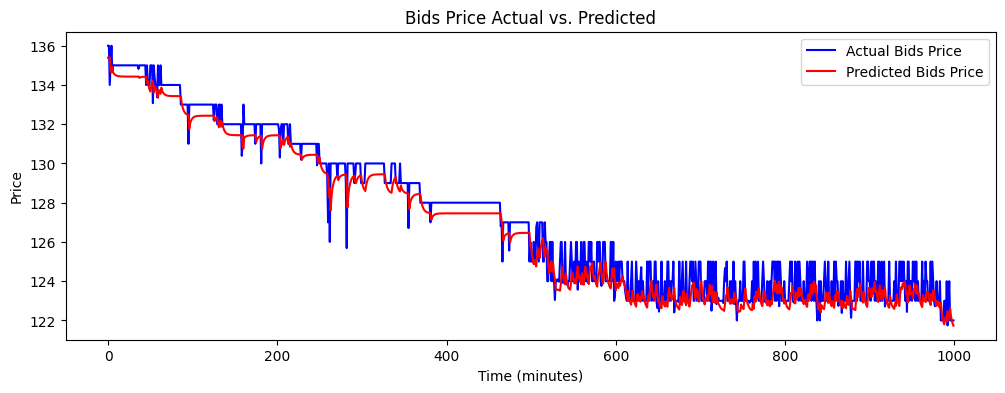

[[135.39256 ]
 [135.40022 ]
 [135.40576 ]
 ...
 [111.674095]
 [111.95264 ]
 [112.13245 ]]
(12738, 1)
Data exported to GRU_predicted_bid_prices.csv


In [160]:
import matplotlib.pyplot as plt

# plot the comparison
plt.figure(figsize=(12, 4))

test_label_bid = scaler_bid.inverse_transform(test_labels_bid.cpu().numpy().flatten().reshape(-1, 1))
predicted_labels_bid = scaler_bid.inverse_transform(np.array(predicted_labels_b).reshape(-1, 1))

plt.plot(test_label_bid[:1000], color='blue', label='Actual Bids Price')
plt.plot(predicted_labels_bid[:1000], color='red', label='Predicted Bids Price')

plt.xlabel('Time (minutes)')
plt.ylabel('Price')
plt.legend()
plt.title('Bids Price Actual vs. Predicted')
plt.show()

print(predicted_labels_bid)
print(predicted_labels_bid.shape)


data = {  
    'BID Price Predicted': predicted_labels_bid.flatten() 
}

df = pd.DataFrame(data)

csv_file_path = 'GRU_predicted_bid_prices.csv'
df.to_csv(csv_file_path, index=False)

print(f"Data exported to {csv_file_path}")



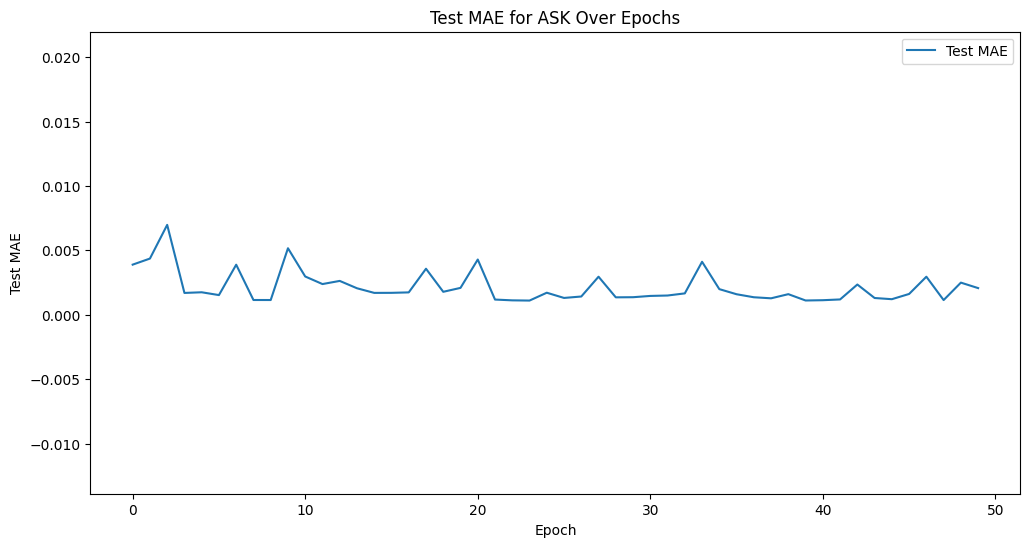

In [151]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_mae_list_b, label='Test MAE')
plt.ylim(min(test_mae_list_b) - 0.015, max(test_mae_list_b) + 0.015)  
plt.xlabel('Epoch')
plt.ylabel('Test MAE')
plt.legend()
plt.title('Test MAE for ASK Over Epochs')
plt.show()

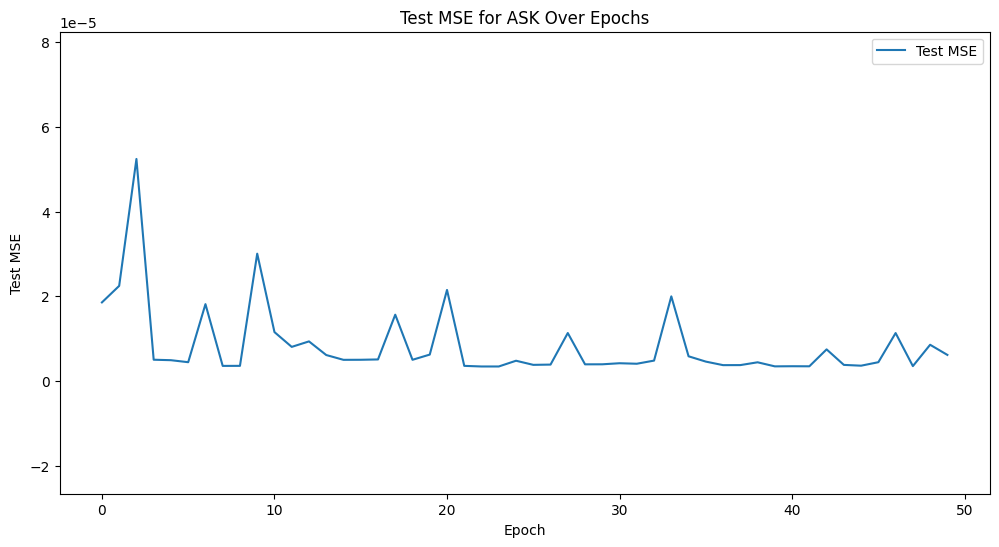

In [152]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_mse_list_b, label='Test MSE')
plt.ylim(min(test_mse_list_b) - 0.00003, max(test_mse_list_b) + 0.00003) 
plt.xlabel('Epoch')
plt.ylabel('Test MSE')
plt.legend()
plt.title('Test MSE for ASK Over Epochs')
plt.show()

[0.004309019707642394, 0.004739836187558627, 0.007237969638958927, 0.0022482697555981663, 0.0022232357489789354, 0.00211420777394623, 0.0042613026395900535, 0.001896218668648032, 0.0018998244411569513, 0.005482743399324461, 0.0034012147051500955, 0.0028428199574184534, 0.003061785316940606, 0.0024821074791206866, 0.0022424490097795163, 0.002245390483258985, 0.0022626013097393365, 0.003958648441422646, 0.0022445418450670373, 0.002503058547151674, 0.004637701041181833, 0.0018989587079175027, 0.001860426600066483, 0.0018602838464409398, 0.0021942993264805846, 0.001960582994695455, 0.0019762043004421708, 0.003368763372344975, 0.0019919238631182353, 0.0019937989991901627, 0.0020554888579049128, 0.0020263068099678526, 0.0022018715685798045, 0.004471282886733855, 0.0024213871649614595, 0.0021471297918150877, 0.0019435821150326107, 0.0019459691125924918, 0.002109127562916122, 0.001868104977900691, 0.0018759352568913368, 0.0018717020448221092, 0.002736899990119612, 0.001958214798011727, 0.00191

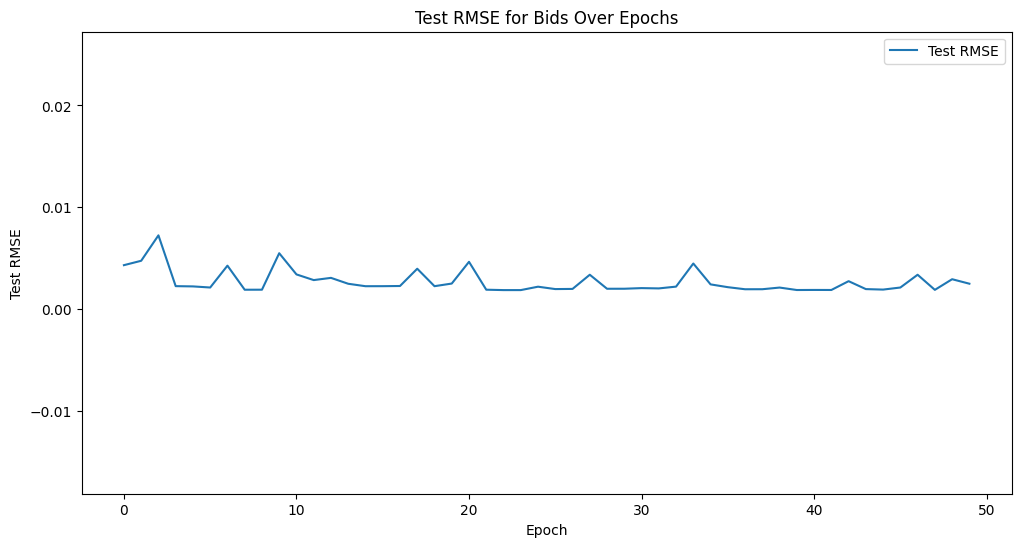

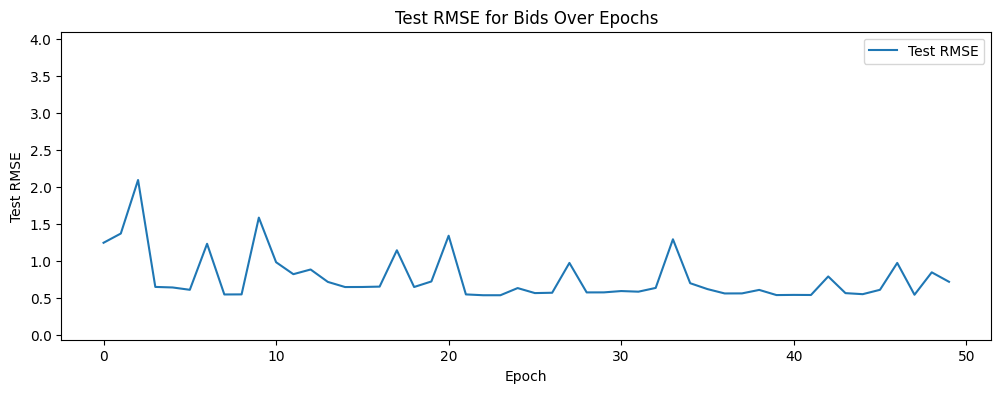

In [161]:
import matplotlib.pyplot as plt

print(test_rmse_list_b)
print(len(test_rmse_list_b))
scaled_rmse_list_b = [x * 289 for x in test_rmse_list_b]
np_array_b = np.array(scaled_rmse_list_b)
np_array_transposed_b = np_array_b.reshape(-1, 1)

print(len(scaled_rmse_list_b))
print(scaled_rmse_list_b)
print(np_array_transposed_b)

plt.figure(figsize=(12, 6))
plt.plot(test_rmse_list_b, label='Test RMSE')
plt.ylim(min(test_rmse_list_b) - 0.02, max(test_rmse_list_b) + 0.02) 
plt.xlabel('Epoch')
plt.ylabel('Test RMSE')
plt.legend()
plt.title('Test RMSE for Bids Over Epochs')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(scaled_rmse_list_b, label='Test RMSE')
plt.ylim(min(scaled_rmse_list_b) - 0.6, max(scaled_rmse_list_b) + 2) 
plt.xlabel('Epoch')
plt.ylabel('Test RMSE')
plt.legend()
plt.title('Test RMSE for Bids Over Epochs')
plt.show()

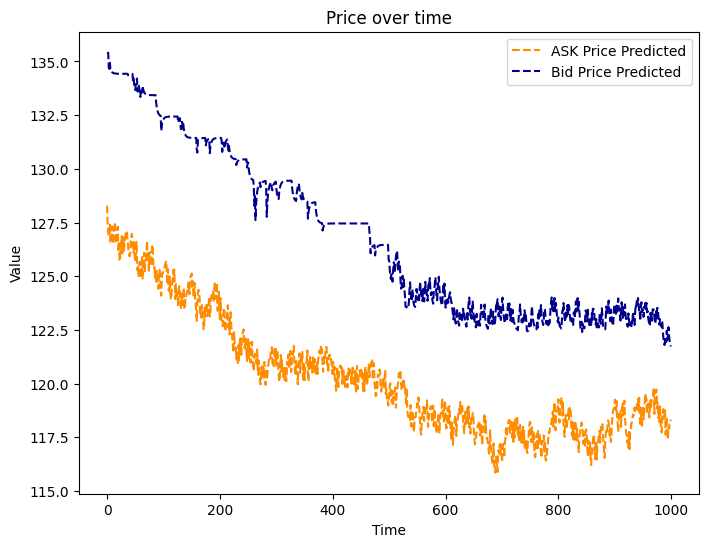

In [155]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

predicted_labels_ask = scaler_ask.inverse_transform(np.array(predicted_labels).reshape(-1, 1))
plt.plot(predicted_labels_ask[:1000], linestyle='dashed', color='darkorange', label='ASK Price Predicted')

predicted_labels_bid = scaler_bid.inverse_transform(np.array(predicted_labels_b).reshape(-1, 1))
plt.plot(predicted_labels_bid[:1000], linestyle='dashed', color='darkblue', label='Bid Price Predicted')

plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Price over time')
plt.show()

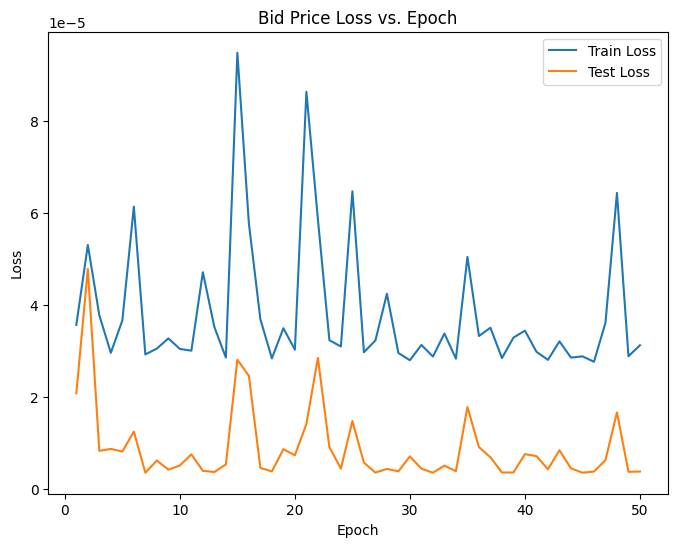

In [47]:
import matplotlib.pyplot as plt

# plot the loss
plt.figure(figsize=(8, 6))
plt.plot(df_results['Epoch'].values, df_results['Train Loss'].values, label='Train Loss')
plt.plot(df_results['Epoch'].values, df_results['Test Loss'].values, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Bid Price Loss vs. Epoch')
plt.show()


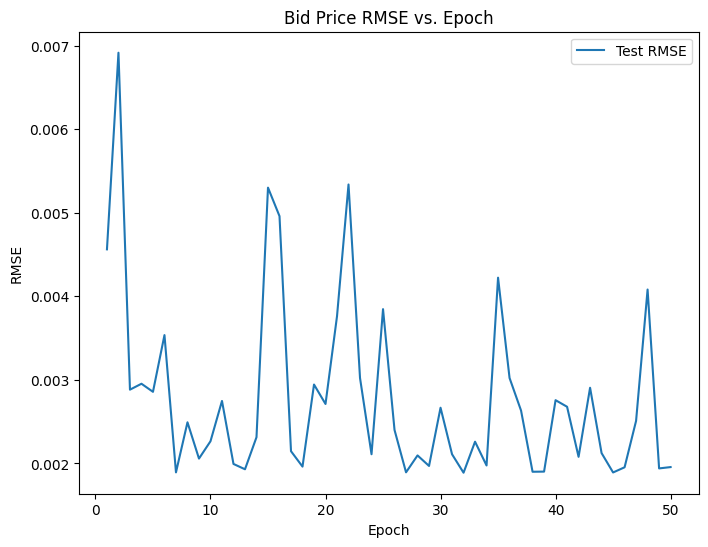

In [48]:
# plot RMSE
plt.figure(figsize=(8, 6))
plt.plot(df_results['Epoch'].values, df_results['Test RMSE'].values, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.title('Bid Price RMSE vs. Epoch')
plt.show()

In [23]:

predicted_prices_ask = np.array(predicted_labels_ask[:50]).flatten()  
predicted_prices_bid = np.array(predicted_labels_bid[:50]).flatten() 

sma_ask = pd.Series(predicted_prices_ask).rolling(window=10).mean()
sma_bid = pd.Series(predicted_prices_bid).rolling(window=10).mean()

buy_signals = predicted_prices_ask < sma_ask  
sell_signals = predicted_prices_bid > sma_bid  

initial_capital = 1000
position = 0  
transaction_costs = 0.001 

for i in range(len(predicted_prices_ask)):
    if buy_signals[i] and initial_capital > 0:  
        units = initial_capital / predicted_prices_ask[i]  
        position += units
        initial_capital -= units * predicted_prices_ask[i]
        initial_capital -= transaction_costs * units * predicted_prices_ask[i] 

    if sell_signals[i] and position > 0:  
        initial_capital += position * predicted_prices_bid[i]
        initial_capital -= transaction_costs * position * predicted_prices_bid[i]  
        position = 0 

final_capital = initial_capital + position * predicted_prices_bid[-1] 
print(f"Final capital after trading: {final_capital}")

return_rate = ((final_capital - 1000) / 1000) * 100
print(f"Return Rate: {return_rate:.2f}%")



Final capital after trading: 1388.1951689433893
Return Rate: 38.82%


In [24]:
import numpy as np
import pandas as pd
import ta

window = 10
close_ask = pd.Series(predicted_labels_ask[:50].flatten())
close_bid = pd.Series(predicted_labels_bid[:50].flatten())

ema1_ask = close_ask.ewm(span=window, adjust=False).mean()
ema2_ask = ema1_ask.ewm(span=window, adjust=False).mean()
ema3_ask = ema2_ask.ewm(span=window, adjust=False).mean()
tema_ask = (3 * ema1_ask) - (3 * ema2_ask) + ema3_ask

ema1_bid = close_bid.ewm(span=window, adjust=False).mean()
ema2_bid = ema1_bid.ewm(span=window, adjust=False).mean()
ema3_bid = ema2_bid.ewm(span=window, adjust=False).mean()
tema_bid = (3 * ema1_bid) - (3 * ema2_bid) + ema3_bid


buy_signals = predicted_labels_ask[:50].flatten() < tema_ask 
sell_signals = predicted_labels_bid[:50].flatten() > tema_bid 

initial_capital = 1000
position = 0 

for i in range(len(predicted_labels_ask[:50])):
    if buy_signals[i] and initial_capital > 0: 
        units = initial_capital / predicted_labels_ask[i]  
        position += units
        initial_capital -= units * predicted_labels_ask[i]

    if sell_signals[i] and position > 0:
        initial_capital += position * predicted_labels_bid[i]
        position = 0 

final_capital = initial_capital + position.item() * predicted_labels_bid[-1].item() 
print(f"Final capital after trading: {final_capital.item()}")

return_rate = ((final_capital.item() - 1000) / 1000) * 100
print(f"Return Rate: {return_rate:.2f}%")


Final capital after trading: 1302.818603515625
Return Rate: 30.28%


Final Portfolio Value: 991.78
Return Rate: -0.82%
     Mid_Price  MACD_Line  Signal_Line      Hist Trade_Signal  Portfolio_Value
0   128.885529   0.000000     0.000000  0.000000         Hold      1000.000000
1   128.896576   0.000881     0.000176  0.000705          Buy      1000.000000
2   128.903702   0.002130     0.000567  0.001563         Hold      1000.055284
3   128.194443  -0.053495    -0.010245 -0.043249         Sell       994.552740
4   128.131882  -0.101457    -0.028488 -0.072969         Hold       994.552740
5   128.424347  -0.114547    -0.045699 -0.068847         Hold       994.552740
6   128.108551  -0.148689    -0.066297 -0.082391         Hold       994.552740
7   128.039108  -0.179283    -0.088894 -0.090389         Hold       994.552740
8   127.992783  -0.204906    -0.112097 -0.092809         Hold       994.552740
9   127.958817  -0.225355    -0.134748 -0.090607         Hold       994.552740
10  127.934807  -0.240724    -0.155943 -0.084780         Hold       994.552740
11

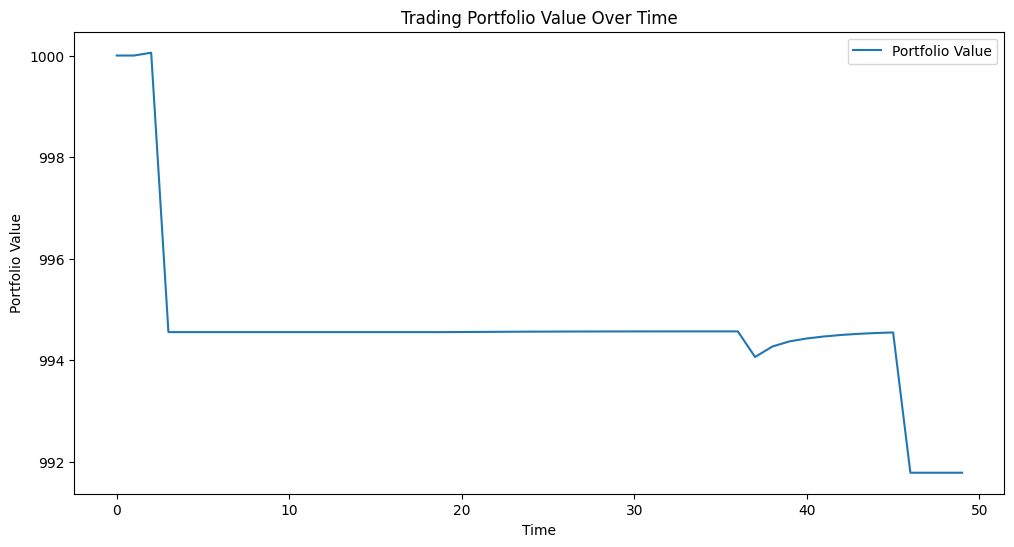

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

predicted_prices_ask = np.array(predicted_labels_ask[:50]).flatten() 
predicted_prices_bid = np.array(predicted_labels_bid[:50]).flatten()  

mid_prices = (np.array(predicted_prices_ask) + np.array(predicted_prices_bid)) / 2

df_results = pd.DataFrame({
    "Mid_Price": mid_prices
})

def ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

def compute_macd(series):
    fast_ema = ema(series, 12)
    slow_ema = ema(series, 26)
    macd_line = fast_ema - slow_ema
    signal_line = ema(macd_line, 9)
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

df_results['MACD_Line'], df_results['Signal_Line'], df_results['Hist'] = compute_macd(df_results['Mid_Price'])

def trade_signals(df):
    signals = []
    for i in range(1, len(df)):
        if df['MACD_Line'].iloc[i] > df['Signal_Line'].iloc[i] and df['MACD_Line'].iloc[i-1] <= df['Signal_Line'].iloc[i-1]:
            signals.append('Buy')
        elif df['MACD_Line'].iloc[i] < df['Signal_Line'].iloc[i] and df['MACD_Line'].iloc[i-1] >= df['Signal_Line'].iloc[i-1]:
            signals.append('Sell')
        else:
            signals.append('Hold')

    signals.insert(0, 'Hold')  
    df['Trade_Signal'] = signals

trade_signals(df_results)

def simulate_trading(df, initial_cash=1000, initial_position=0):
    cash = initial_cash  
    position = initial_position  
    portfolio_value = []  

    for i, row in df.iterrows():
        price = row['Mid_Price']
        signal = row['Trade_Signal']

        if signal == 'Buy' and cash > 0:
           
            position = cash / price
            cash = 0
        elif signal == 'Sell' and position > 0:
          
            cash = position * price
            position = 0

        portfolio_value.append(cash + position * price)

    df['Portfolio_Value'] = portfolio_value

    final_portfolio_value = portfolio_value[-1]
    return_rate = (final_portfolio_value - initial_cash) / initial_cash

    print(f'Final Portfolio Value: {final_portfolio_value:.2f}')
    print(f'Return Rate: {return_rate * 100:.2f}%')

simulate_trading(df_results)

print(df_results[['Mid_Price', 'MACD_Line', 'Signal_Line', 'Hist', 'Trade_Signal', 'Portfolio_Value']])

plt.figure(figsize=(12, 6))
plt.plot(df_results['Portfolio_Value'], label='Portfolio Value')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()
plt.title('Trading Portfolio Value Over Time')
plt.show()




Final Portfolio Value: 995.25
Return Rate: -0.48%
     Mid_Price         RSI Trade_Signal  Portfolio_Value
0   128.885529         NaN         Hold      1000.000000
1   128.896576         NaN         Hold      1000.000000
2   128.903702         NaN         Hold      1000.000000
3   128.194443         NaN         Hold      1000.000000
4   128.131882         NaN         Hold      1000.000000
5   128.424347         NaN         Hold      1000.000000
6   128.108551         NaN         Hold      1000.000000
7   128.039108         NaN         Hold      1000.000000
8   127.992783         NaN         Hold      1000.000000
9   127.958817         NaN         Hold      1000.000000
10  127.934807         NaN         Hold      1000.000000
11  127.918640         NaN         Hold      1000.000000
12  127.908157         NaN         Hold      1000.000000
13  127.901581   19.351711          Buy      1000.000000
14  127.897621   19.304093          Buy       999.969041
15  127.895370   18.719907          Bu

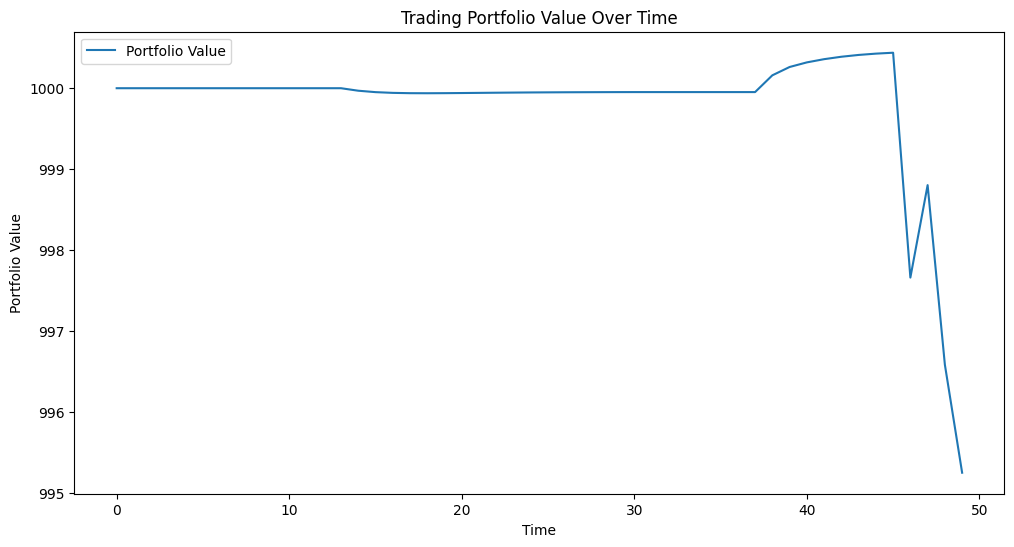

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

predicted_prices_ask = np.array(predicted_labels_ask[:50]).flatten()  
predicted_prices_bid = np.array(predicted_labels_bid[:50]).flatten() 

mid_prices = (np.array(predicted_prices_ask) + np.array(predicted_prices_bid)) / 2

df_results = pd.DataFrame({
    "Mid_Price": mid_prices
})

def compute_rsi(series, period=14):
    delta = series.diff()

    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (abs(delta.where(delta < 0, 0))).rolling(window=period).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

df_results['RSI'] = compute_rsi(df_results['Mid_Price'])

def trade_signals(df, overbought=70, oversold=30):
    signals = []
    for i in range(len(df)):
        rsi = df['RSI'].iloc[i]
        if rsi > overbought:
            signals.append('Sell')
        elif rsi < oversold:
            signals.append('Buy')
        else:
            signals.append('Hold')

    df['Trade_Signal'] = signals

trade_signals(df_results)

def simulate_trading(df, initial_cash=1000, initial_position=0):
    cash = initial_cash 
    position = initial_position  
    portfolio_value = []  

    for i, row in df.iterrows():
        price = row['Mid_Price']
        signal = row['Trade_Signal']

        if signal == 'Buy' and cash > 0:
          
            position = cash / price
            cash = 0
        elif signal == 'Sell' and position > 0:
            
            cash = position * price
            position = 0

        
        portfolio_value.append(cash + position * price)

    df['Portfolio_Value'] = portfolio_value

    final_portfolio_value = portfolio_value[-1]
    return_rate = (final_portfolio_value - initial_cash) / initial_cash

    print(f'Final Portfolio Value: {final_portfolio_value:.2f}')
    print(f'Return Rate: {return_rate * 100:.2f}%')

simulate_trading(df_results)

print(df_results[['Mid_Price', 'RSI', 'Trade_Signal', 'Portfolio_Value']])

plt.figure(figsize=(12, 6))
plt.plot(df_results['Portfolio_Value'], label='Portfolio Value')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()
plt.title('Trading Portfolio Value Over Time')
plt.show()
